In [2]:
import numpy as np
import os.path as op
import os 
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def read_montage(kind, ch_names=None, path=None, unit='m', transform=False):
    """Read a generic (built-in) montage.

    Individualized (digitized) electrode positions should be read in using
    :func:`read_dig_montage`.

    In most cases, you should only need to set the `kind` parameter to load one
    of the built-in montages (see Notes).

    Parameters
    ----------
    kind : str
        The name of the montage file without the file extension (e.g.
        kind='easycap-M10' for 'easycap-M10.txt'). Files with extensions
        '.elc', '.txt', '.csd', '.elp', '.hpts', '.sfp', '.loc' ('.locs' and
        '.eloc') or .bvef are supported.
    ch_names : list of str | None
        If not all electrodes defined in the montage are present in the EEG
        data, use this parameter to select a subset of electrode positions to
        load. If None (default), all defined electrode positions are returned.


        .. note:: ``ch_names`` are compared to channel names in the montage
                  file after converting them both to upper case. If a match is
                  found, the letter case in the original ``ch_names`` is used
                  in the returned montage.

    path : str | None
        The path of the folder containing the montage file. Defaults to the
        mne/channels/data/montages folder in your mne-python installation.
    unit : 'm' | 'cm' | 'mm'
        Unit of the input file. If not 'm' (default), coordinates will be
        rescaled to 'm'.
    transform : bool
        If True, points will be transformed to Neuromag space. The fidicuals,
        'nasion', 'lpa', 'rpa' must be specified in the montage file. Useful
        for points captured using Polhemus FastSCAN. Default is False.

    Returns
    -------
    montage : instance of Montage
        The montage.

    See Also
    --------
    DigMontage
    Montage
    read_dig_montage

    Notes
    -----
    Built-in montages are not scaled or transformed by default.

    Montages can contain fiducial points in addition to electrode channels,
    e.g. ``biosemi64`` contains 67 locations. In the following table, the
    number of channels and fiducials is given in parentheses in the description
    column (e.g. 64+3 means 64 channels and 3 fiducials).

    Valid ``kind`` arguments are:

    ===================   =====================================================
    Kind                  Description
    ===================   =====================================================
    standard_1005         Electrodes are named and positioned according to the
                          international 10-05 system (343+3 locations)
    standard_1020         Electrodes are named and positioned according to the
                          international 10-20 system (94+3 locations)
    standard_alphabetic   Electrodes are named with LETTER-NUMBER combinations
                          (A1, B2, F4, ...) (65+3 locations)
    standard_postfixed    Electrodes are named according to the international
                          10-20 system using postfixes for intermediate
                          positions (100+3 locations)
    standard_prefixed     Electrodes are named according to the international
                          10-20 system using prefixes for intermediate
                          positions (74+3 locations)
    standard_primed       Electrodes are named according to the international
                          10-20 system using prime marks (' and '') for
                          intermediate positions (100+3 locations)

    biosemi16             BioSemi cap with 16 electrodes (16+3 locations)
    biosemi32             BioSemi cap with 32 electrodes (32+3 locations)
    biosemi64             BioSemi cap with 64 electrodes (64+3 locations)
    biosemi128            BioSemi cap with 128 electrodes (128+3 locations)
    biosemi160            BioSemi cap with 160 electrodes (160+3 locations)
    biosemi256            BioSemi cap with 256 electrodes (256+3 locations)

    easycap-M1            EasyCap with 10-05 electrode names (74 locations)
    easycap-M10           EasyCap with numbered electrodes (61 locations)

    EGI_256               Geodesic Sensor Net (256 locations)

    GSN-HydroCel-32       HydroCel Geodesic Sensor Net and Cz (33+3 locations)
    GSN-HydroCel-64_1.0   HydroCel Geodesic Sensor Net (64+3 locations)
    GSN-HydroCel-65_1.0   HydroCel Geodesic Sensor Net and Cz (65+3 locations)
    GSN-HydroCel-128      HydroCel Geodesic Sensor Net (128+3 locations)
    GSN-HydroCel-129      HydroCel Geodesic Sensor Net and Cz (129+3 locations)
    GSN-HydroCel-256      HydroCel Geodesic Sensor Net (256+3 locations)
    GSN-HydroCel-257      HydroCel Geodesic Sensor Net and Cz (257+3 locations)

    mgh60                 The (older) 60-channel cap used at
                          MGH (60+3 locations)
    mgh70                 The (newer) 70-channel BrainVision cap used at
                          MGH (70+3 locations)
    ===================   =====================================================

    .. versionadded:: 0.9.0
    """
    if path is None:
        path = op.join(op.dirname(__file__), 'data', 'montages')
    if not op.isabs(kind):
        supported = ('.elc', '.txt', '.csd', '.sfp', '.elp', '.hpts', '.loc',
                     '.locs', '.eloc', '.bvef')
        montages = [op.splitext(f) for f in os.listdir(path)]
        montages = [m for m in montages if m[1] in supported and kind == m[0]]
        if len(montages) != 1:
            raise ValueError('Could not find the montage. Please provide the '
                             'full path.')
        kind, ext = montages[0]
    else:
        kind, ext = op.splitext(kind)
    fname = op.join(path, kind + ext)

    fid_names = ['lpa', 'nz', 'rpa']
    if ext == '.sfp':
        # EGI geodesic
        fid_names = ['fidt9', 'fidnz', 'fidt10']
        with open(fname, 'r') as f:
            lines = f.read().replace('\t', ' ').splitlines()

        ch_names_, pos = [], []
        for ii, line in enumerate(lines):
            line = line.strip().split()
            if len(line) > 0:  # skip empty lines
                if len(line) != 4:  # name, x, y, z
                    raise ValueError("Malformed .sfp file in line " + str(ii))
                this_name, x, y, z = line
                ch_names_.append(this_name)
                pos.append([float(cord) for cord in (x, y, z)])
        pos = np.asarray(pos)
    elif ext == '.elc':
        # 10-5 system
        ch_names_ = []
        pos = []
        with open(fname) as fid:
            # Default units are meters
            for line in fid:
                if 'UnitPosition' in line:
                    units = line.split()[1]
                    scale_factor = dict(m=1., mm=1e-3)[units]
                    break
            else:
                raise RuntimeError('Could not detect units in file %s' % fname)
            for line in fid:
                if 'Positions\n' in line:
                    break
            pos = []
            for line in fid:
                if 'Labels\n' in line:
                    break
                pos.append(list(map(float, line.split())))
            for line in fid:
                if not line or not set(line) - set([' ']):
                    break
                ch_names_.append(line.strip(' ').strip('\n'))
        pos = np.array(pos) * scale_factor
    elif ext == '.txt':
        # easycap
        try:  # newer version
            data = np.genfromtxt(fname, dtype='str', skip_header=1)
        except TypeError:
            data = np.genfromtxt(fname, dtype='str', skiprows=1)
        ch_names_ = data[:, 0].tolist()
        az = np.deg2rad(data[:, 2].astype(float))
        pol = np.deg2rad(data[:, 1].astype(float))
        pos = _sph_to_cart(np.array([np.ones(len(az)) * 85., az, pol]).T)
    elif ext == '.csd':
        # CSD toolbox
        try:  # newer version
            data = np.genfromtxt(fname, dtype='str', skip_header=2)
        except TypeError:
            data = np.genfromtxt(fname, dtype='str', skiprows=2)

        ch_names_ = data[:, 0].tolist()
        az = np.deg2rad(data[:, 1].astype(float))
        pol = np.deg2rad(90. - data[:, 2].astype(float))
        pos = _sph_to_cart(np.array([np.ones(len(az)), az, pol]).T)
    elif ext == '.elp':
        # standard BESA spherical
        dtype = np.dtype('S8, S8, f8, f8, f8')
        try:
            data = np.loadtxt(fname, dtype=dtype, skip_header=1)
        except TypeError:
            data = np.loadtxt(fname, dtype=dtype, skiprows=1)

        ch_names_ = data['f1'].astype(str).tolist()
        az = data['f2']
        horiz = data['f3']
        radius = np.abs(az / 180.)
        az = np.deg2rad(np.array([h if a >= 0. else 180 + h
                                  for h, a in zip(horiz, az)]))
        pol = radius * np.pi
        pos = _sph_to_cart(np.array([np.ones(len(az)) * 85., az, pol]).T)
    elif ext == '.hpts':
        # MNE-C specified format for generic digitizer data
        fid_names = ['1', '2', '3']
        dtype = [('type', 'S8'), ('name', 'S8'),
                 ('x', 'f8'), ('y', 'f8'), ('z', 'f8')]
        data = np.loadtxt(fname, dtype=dtype)
        ch_names_ = data['name'].astype(str).tolist()
        pos = np.vstack((data['x'], data['y'], data['z'])).T
    elif ext in ('.loc', '.locs', '.eloc'):
        ch_names_ = np.loadtxt(fname, dtype='S4',
                               usecols=[3]).astype(str).tolist()
        topo = np.loadtxt(fname, dtype=float, usecols=[1, 2])
        sph = _topo_to_sph(topo)
        pos = _sph_to_cart(sph)
        pos[:, [0, 1]] = pos[:, [1, 0]] * [-1, 1]
    elif ext == '.bvef':
        # 'BrainVision Electrodes File' format
        root = ElementTree.parse(fname).getroot()
        ch_names_ = [s.text for s in root.findall("./Electrode/Name")]
        theta = [float(s.text) for s in root.findall("./Electrode/Theta")]
        pol = np.deg2rad(np.array(theta))
        phi = [float(s.text) for s in root.findall("./Electrode/Phi")]
        az = np.deg2rad(np.array(phi))
        pos = _sph_to_cart(np.array([np.ones(len(az)) * 85., az, pol]).T)
    else:
        raise ValueError('Currently the "%s" template is not supported.' %
                         kind)
    selection = np.arange(len(pos))

    if unit == 'mm':
        pos /= 1e3
    elif unit == 'cm':
        pos /= 1e2
    elif unit != 'm':
        raise ValueError("'unit' should be either 'm', 'cm', or 'mm'.")
    names_lower = [name.lower() for name in list(ch_names_)]
    fids = {key: pos[names_lower.index(fid_names[ii])]
            if fid_names[ii] in names_lower else None
            for ii, key in enumerate(['lpa', 'nasion', 'rpa'])}
    if transform:
        missing = [name for name, val in fids.items() if val is None]
        if missing:
            raise ValueError("The points %s are missing, but are needed "
                             "to transform the points to the MNE coordinate "
                             "system. Either add the points, or read the "
                             "montage with transform=False. " % missing)
        neuromag_trans = get_ras_to_neuromag_trans(
            fids['nasion'], fids['lpa'], fids['rpa'])
        pos = apply_trans(neuromag_trans, pos)
    fids = {key: pos[names_lower.index(fid_names[ii])]
            if fid_names[ii] in names_lower else None
            for ii, key in enumerate(['lpa', 'nasion', 'rpa'])}

    if ch_names is not None:
        # Ensure channels with differing case are found.
        upper_names = [ch_name.upper() for ch_name in ch_names]
        sel, ch_names_ = zip(*[(i, ch_names[upper_names.index(e)]) for i, e in
                               enumerate([n.upper() for n in ch_names_])
                               if e in upper_names])
        sel = list(sel)
        pos = pos[sel]
        selection = selection[sel]
    kind = op.split(kind)[-1]
    return pos, ch_names_, kind

def _cart_to_sph(cart):
    """Convert Cartesian coordinates to spherical coordinates.

    Parameters
    ----------
    cart_pts : ndarray, shape (n_points, 3)
        Array containing points in Cartesian coordinates (x, y, z)

    Returns
    -------
    sph_pts : ndarray, shape (n_points, 3)
        Array containing points in spherical coordinates (rad, azimuth, polar)
    """
    assert cart.ndim == 2 and cart.shape[1] == 3
    cart = np.atleast_2d(cart)
    out = np.empty((len(cart), 3))
    out[:, 0] = np.sqrt(np.sum(cart * cart, axis=1))
    out[:, 1] = np.arctan2(cart[:, 1], cart[:, 0])
    out[:, 2] = np.arccos(cart[:, 2] / out[:, 0])
    out = np.nan_to_num(out)
    return out


def _sph_to_cart(sph):
    """Convert spherical coordinates to Cartesion coordinates."""
    assert sph.ndim == 2 and sph.shape[1] == 3
    sph = np.atleast_2d(sph)
    out = np.empty((len(sph), 3))
    out[:, 2] = sph[:, 0] * np.cos(sph[:, 2])
    xy = sph[:, 0] * np.sin(sph[:, 2])
    out[:, 0] = xy * np.cos(sph[:, 1])
    out[:, 1] = xy * np.sin(sph[:, 1])
    return out

def _pol_to_cart(pol):
    """Transform polar coordinates to cartesian."""
    out = np.empty((len(pol), 2))
    if pol.shape[1] == 2:  # phi, theta
        out[:, 0] = pol[:, 0] * np.cos(pol[:, 1])
        out[:, 1] = pol[:, 0] * np.sin(pol[:, 1])
    else:  # radial distance, theta, phi
        d = pol[:, 0] * np.sin(pol[:, 2])
        out[:, 0] = d * np.cos(pol[:, 1])
        out[:, 1] = d * np.sin(pol[:, 1])
    return out


In [25]:
def getLayout(kind, ch_names_in_use):
    '''
    kind : str
        The name of the montage file without the file extension (e.g.
        kind='easycap-M10' for 'easycap-M10.txt'). Files with extensions
        '.elc', '.txt', '.csd', '.elp', '.hpts', '.sfp', '.loc' ('.locs' and
        '.eloc') or .bvef are supported.
    
    ch_names_in_use: the ch_names from epoch info.
    
    
    Valid ``kind`` arguments are:

    ===================   =====================================================
    Kind                  Description
    ===================   =====================================================
    standard_1005         Electrodes are named and positioned according to the
                          international 10-05 system (343+3 locations)
    standard_1020         Electrodes are named and positioned according to the
                          international 10-20 system (94+3 locations)
    standard_alphabetic   Electrodes are named with LETTER-NUMBER combinations
                          (A1, B2, F4, ...) (65+3 locations)
    standard_postfixed    Electrodes are named according to the international
                          10-20 system using postfixes for intermediate
                          positions (100+3 locations)
    standard_prefixed     Electrodes are named according to the international
                          10-20 system using prefixes for intermediate
                          positions (74+3 locations)
    standard_primed       Electrodes are named according to the international
                          10-20 system using prime marks (' and '') for
                          intermediate positions (100+3 locations)

    biosemi16             BioSemi cap with 16 electrodes (16+3 locations)
    biosemi32             BioSemi cap with 32 electrodes (32+3 locations)
    biosemi64             BioSemi cap with 64 electrodes (64+3 locations)
    biosemi128            BioSemi cap with 128 electrodes (128+3 locations)
    biosemi160            BioSemi cap with 160 electrodes (160+3 locations)
    biosemi256            BioSemi cap with 256 electrodes (256+3 locations)

    easycap-M1            EasyCap with 10-05 electrode names (74 locations)
    easycap-M10           EasyCap with numbered electrodes (61 locations)

    EGI_256               Geodesic Sensor Net (256 locations)

    GSN-HydroCel-32       HydroCel Geodesic Sensor Net and Cz (33+3 locations)
    GSN-HydroCel-64_1.0   HydroCel Geodesic Sensor Net (64+3 locations)
    GSN-HydroCel-65_1.0   HydroCel Geodesic Sensor Net and Cz (65+3 locations)
    GSN-HydroCel-128      HydroCel Geodesic Sensor Net (128+3 locations)
    GSN-HydroCel-129      HydroCel Geodesic Sensor Net and Cz (129+3 locations)
    GSN-HydroCel-256      HydroCel Geodesic Sensor Net (256+3 locations)
    GSN-HydroCel-257      HydroCel Geodesic Sensor Net and Cz (257+3 locations)

    mgh60                 The (older) 60-channel cap used at
                          MGH (60+3 locations)
    mgh70                 The (newer) 70-channel BrainVision cap used at
                          MGH (70+3 locations)
    ===================   =====================================================
        
    '''
    
    
    path =".\Layout\montages\\"
    
    # read the montage and get 3d positions of electrodes
    pos, ch_names, _ =  read_montage(kind = kind, path = path)
    # turn 3d pos to 2d pos
    pos2d = _pol_to_cart(_cart_to_sph(pos)[:, 1:][:, ::-1])
    
    # organize channel names and 2d pos into a dataframe
    df = pd.DataFrame(np.append(np.array(ch_names).reshape(-1,1), pos2d, axis = 1), columns = ['name', 'x', 'y'])
    df[['x','y']] = df[['x','y']].apply(pd.to_numeric)

    # select and sort channels according to the channel order in epoch info
    df_in_use = df.loc[df['name'].isin(ch_names_in_use)].copy()
    df_in_use.name = pd.Categorical(df_in_use.name, categories = ch_names_in_use, ordered = True)
    df_in_use = df_in_use.sort_values('name')
    df_in_use = df_in_use.reset_index(drop=True)
    
    # xy_locs = dict([(ch,[x,y]) for ch,(x,y) in zip(ch_names,new_pos)])
    return df_in_use

In [5]:
import mne

In [6]:
epoch = mne.read_epochs('Data/siqiData/follow_up_fif/e0032-epo.fif')

Reading Data/siqiData/follow_up_fif/e0032-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 32) active
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
284 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
284 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [20]:
layout, _  = getLayout('standard_1005',epoch.ch_names)

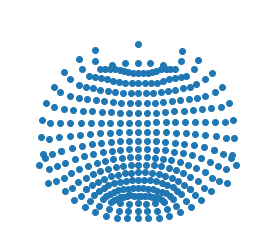

In [23]:
plt.scatter(layout.x, layout.y)
# for i in range(32):
#     plt.annotate(layout.loc[i, 'name'], xy = (layout.loc[i, 'x'], layout.loc[i,'y']))
    
_ = plt.axis('square')
_ = plt.axis('off')

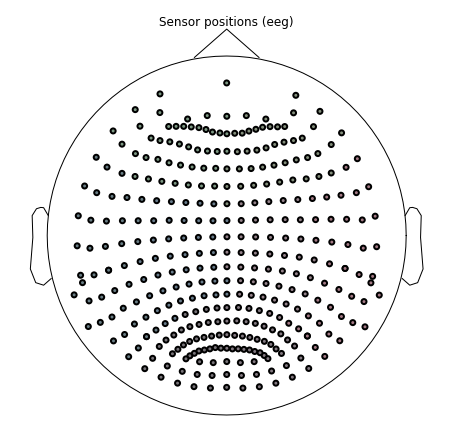

In [24]:
################################################################
## for reference plot_sensors from mne package.
# import mne
# def plot_montage(montage):
#     if isinstance(montage, str):
#         montage = mne.channels.read_montage(montage)
#     info = mne.create_info(montage.ch_names, sfreq=256, ch_types="eeg",
#                            montage=montage)
#     mne.viz.plot_sensors(info, show_names=False, ch_groups='position')


# plot_montage("standard_1005")